In [548]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [549]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [550]:
plt.style.use('science')
sns.set_theme()

In [551]:
plt.rcParams['figure.figsize'] = (8, 4)

## 1. Загрузка данных

In [552]:
df: pd.DataFrame = pd.read_csv('data/cars_sampled.csv')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18


## 2. Описательная статистика

In [553]:
# все числовые данные уже в формате int64

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          50001 non-null  object
 1   name                 50001 non-null  object
 2   seller               50001 non-null  object
 3   offerType            50001 non-null  object
 4   price                50001 non-null  int64 
 5   abtest               50001 non-null  object
 6   vehicleType          44813 non-null  object
 7   yearOfRegistration   50001 non-null  int64 
 8   gearbox              47177 non-null  object
 9   powerPS              50001 non-null  int64 
 10  model                47243 non-null  object
 11  kilometer            50001 non-null  int64 
 12  monthOfRegistration  50001 non-null  int64 
 13  fuelType             45498 non-null  object
 14  brand                50001 non-null  object
 15  notRepairedDamage    40285 non-null  object
 16  date

In [554]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
count,5.000100e+04,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,6.559865e+03,2005.544229,116.496130,125613.687726,5.743725,50775.216696
std,8.581847e+04,122.991832,230.567709,40205.234483,3.711345,25743.701933
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1.150000e+03,1999.000000,69.000000,125000.000000,3.000000,30559.000000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,49504.000000
75%,7.190000e+03,2008.000000,150.000000,150000.000000,9.000000,71404.000000
max,1.234568e+07,9999.000000,19312.000000,150000.000000,12.000000,99998.000000


## 4. Работа с `price`

In [555]:
tidy = df.copy()

In [556]:
price = tidy['price']
len(price), price.min(), price.max()

(50001, 0, 12345678)

In [557]:
# значения 0 и 1 являются странными для цены

price[price < price.quantile(0.1)].value_counts().sort_index()[:20]

0     1451
1      172
2        1
3        1
5        4
7        1
8        2
10       5
11       1
12       1
14       1
15       8
20       6
21       1
25       5
26       1
30       7
35       4
39       1
40       3
Name: price, dtype: int64

In [558]:
price_ = price[price > 10]
len(price_)

48364

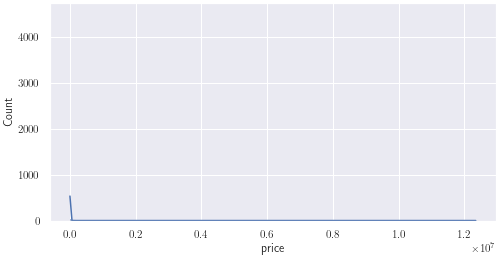

In [559]:
# малое количество очень больших значений не позволяет построить информативный график

sns.histplot(x=price_, kde=True);

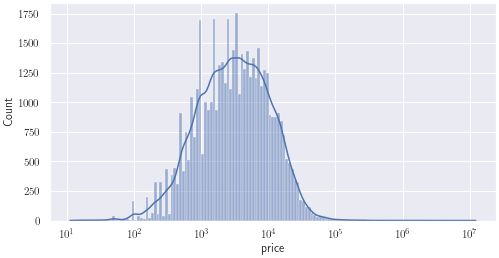

In [560]:
# логарифмируем значение цены

sns.histplot(x=price_, kde=True, log_scale=True);

In [561]:
price_ = np.log(price_)

(2.3978952727983707, 16.32881660027397)

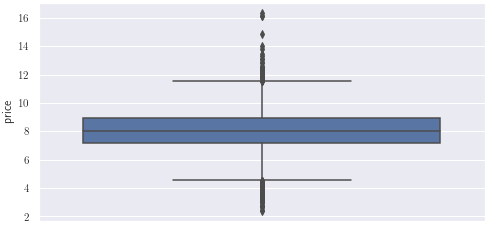

In [562]:
# на графике наглядно представлены выбросы

sns.boxplot(y=price_)
price_.min(), price_.max()

In [563]:
# удаляю выбросы с помощью IQR

q_1, q_3 = price_.quantile([0.25, 0.75])
iqr = q_3 - q_1
left = q_1 - 1.5 * iqr
right = q_3 + 1.5 * iqr
print(
    f'Q1 = {q_1:.2f}, Q3 = {q_3:.2f}\n'
    f'IQR = {iqr:.2f}\n'
    f'[{left:.2f};{right:.2f}]'
)

price_ = price_[(price_ > left) & (price_ < right)]
len(price_)

Q1 = 7.16, Q3 = 8.92
IQR = 1.76
[4.52;11.56]


48179

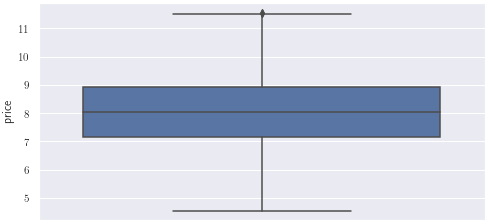

In [564]:
sns.boxplot(y=price_);

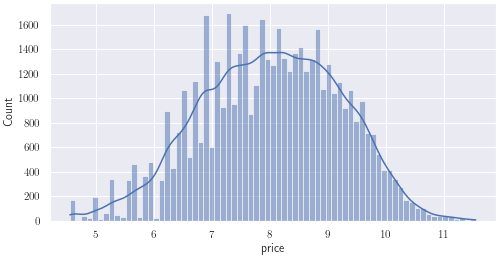

In [565]:
# получили распределение близкое к нормальному

sns.histplot(x=price_, kde=True);

In [566]:
tidy: pd.DataFrame = tidy.loc[price_.index]
tidy['price'] = price_
tidy.shape

(48179, 19)

## 5. Работа с важными для `price` параметрами

In [567]:
def drop_iqr(s: pd.Series) -> pd.Series:
    q_1, q_3 = s.quantile([0.25, 0.75])
    iqr = q_3 - q_1
    return s[(s > q_1 - 1.5 * iqr) & (s < q_3 + 1.5 * iqr)]

In [568]:
tidy.corr()['price']

price                  1.000000
yearOfRegistration     0.035684
powerPS                0.166172
kilometer             -0.372208
monthOfRegistration    0.130828
postalCode             0.087792
Name: price, dtype: float64

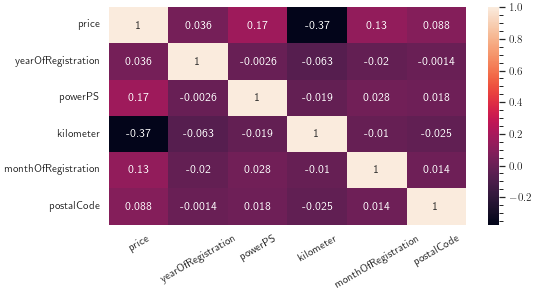

In [569]:
ax = sns.heatmap(tidy.corr(), annot=True)
ax.tick_params(axis='x', rotation=30)

Работа с `kilometer`

In [570]:
kilometer = tidy['kilometer']
len(kilometer), kilometer.min(), kilometer.max()

(48179, 5000, 150000)

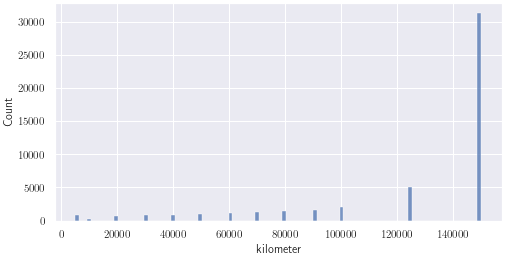

In [571]:
sns.histplot(x=kilometer);

(5000, 150000)

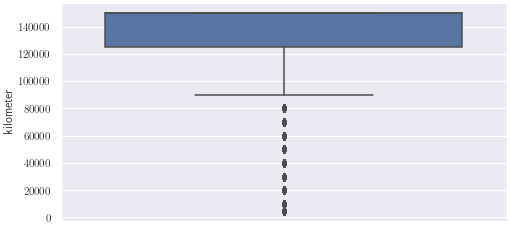

In [572]:
sns.boxplot(y=kilometer)
kilometer.min(), kilometer.max()

In [573]:
kilometer_ = drop_iqr(kilometer)
len(kilometer_)

39900

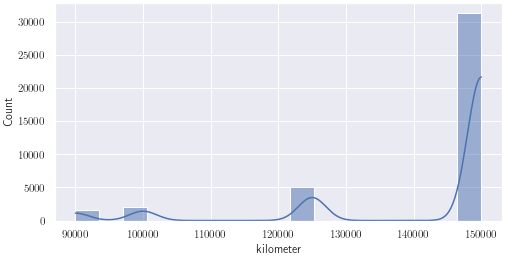

In [574]:
sns.histplot(x=kilometer_, kde=True);

(90000, 150000)

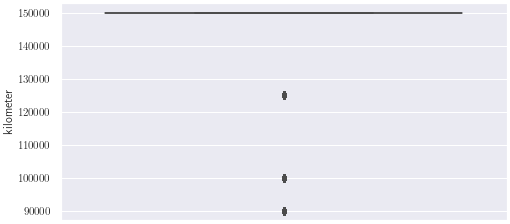

In [575]:
# принято решение не изменять параметр kilometer

sns.boxplot(y=kilometer_)
kilometer_.min(), kilometer_.max()

Работа с `powerPS`

In [576]:
power_ps = tidy['powerPS']
print(len(power_ps))
print(pd.Series(power_ps.unique()).nsmallest(5).tolist())
print(power_ps.nlargest(5).tolist())

48179
[0, 1, 2, 3, 4]
[19312, 19211, 16312, 16011, 15033]


In [577]:
power_ps_ = power_ps[power_ps > 0]

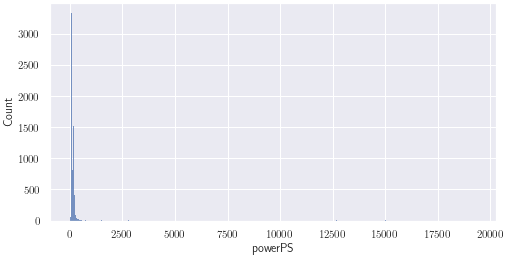

In [578]:
sns.histplot(x=power_ps_);

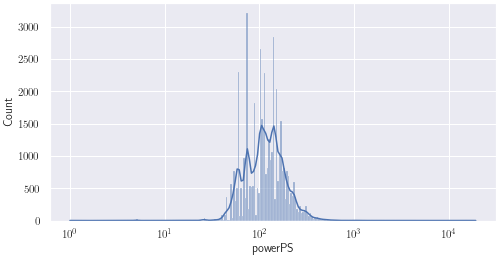

In [579]:
sns.histplot(x=power_ps_, kde=True, log_scale=True);

In [580]:
power_ps_ = np.log(power_ps_)

(0.0, 9.868481943337313)

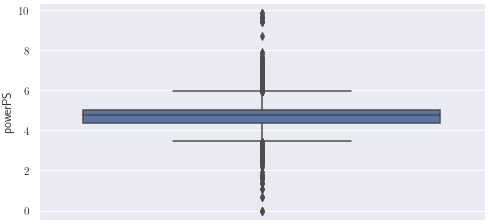

In [581]:
sns.boxplot(y=power_ps_)
power_ps_.min(), power_ps_.max()

In [582]:
power_ps_ = drop_iqr(power_ps_)
len(power_ps_)

42851

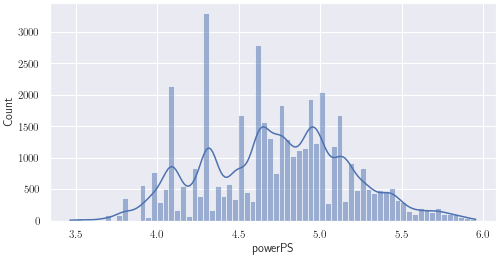

In [583]:
sns.histplot(x=power_ps_, kde=True);

(3.4657359027997265, 5.953243334287785)

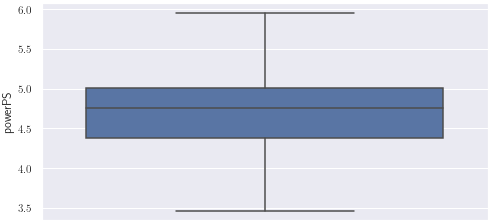

In [584]:
sns.boxplot(y=power_ps_)
power_ps_.min(), power_ps_.max()

In [585]:
tidy: pd.DataFrame = tidy.loc[power_ps_.index]
tidy['powerPS'] = power_ps_
tidy.shape

(42851, 19)

Пересчет корреляций с исправленными признаками

In [586]:
tidy[['price', 'powerPS', 'kilometer']].corr()['price']

price        1.000000
powerPS      0.574885
kilometer   -0.412513
Name: price, dtype: float64

## 6. Нечисловые данные

In [587]:
print('Шкалы нечисловых данных:')
print(f'gearbox: {tidy["gearbox"].unique().tolist()}')
print(f'fuelType: {tidy["fuelType"].unique().tolist()}')
print(f'vehicleType: {tidy["vehicleType"].unique().tolist()}')
print(f'notRepairedDamage: {tidy["notRepairedDamage"].unique().tolist()}')

Шкалы нечисловых данных:
gearbox: ['manual', 'automatic', nan]
fuelType: ['diesel', 'petrol', nan, 'cng', 'lpg', 'hybrid', 'other', 'electro']
vehicleType: ['limousine', 'suv', 'bus', 'small car', 'coupe', 'station wagon', nan, 'others', 'cabrio']
notRepairedDamage: [nan, 'no', 'yes']


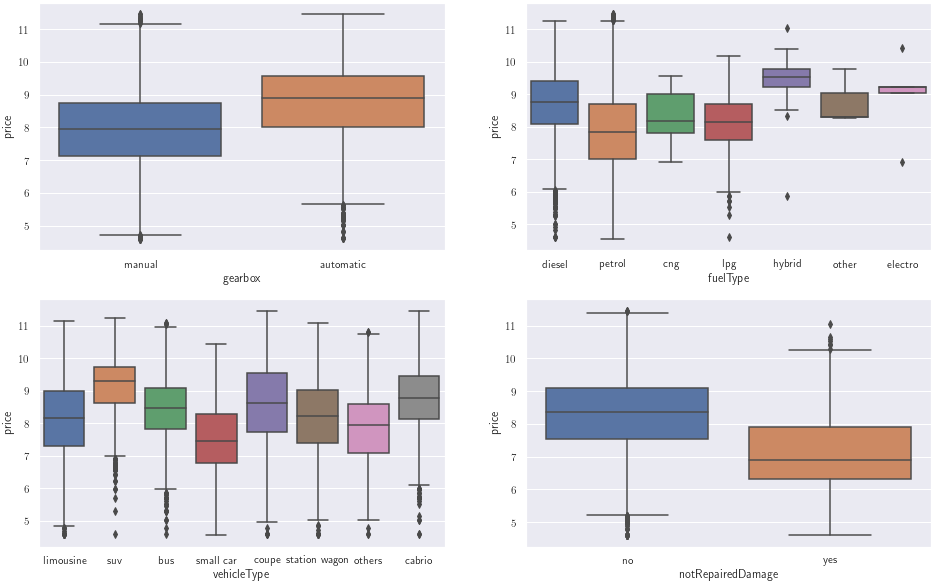

In [588]:
# ящиковые диаграммы зависимости gearbox, fuelType, vehicleType, notRepairedDamage от price

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axes.flatten(), ['gearbox', 'fuelType', 'vehicleType', 'notRepairedDamage']):
    sns.boxplot(data=tidy, x=col, y='price', ax=ax)

1) автомобили с автоматической коробкой передач в среднем дороже автомобилей с механикой
2) электромобили и автомобили с гибридным типом потребления топлива стоят дороже, чем автомобили с бензиновым двигателем. Но автомобилей с бензиновым двигателем гораздо больше
3) автомобили без повреждений дороже восстановленных автомобилей

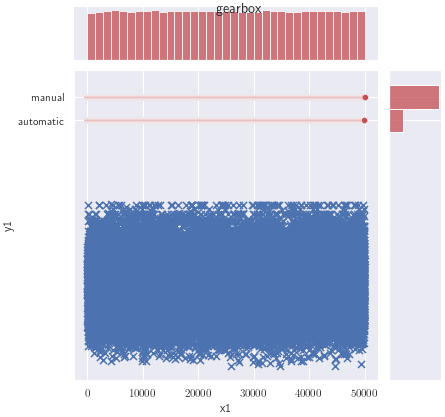

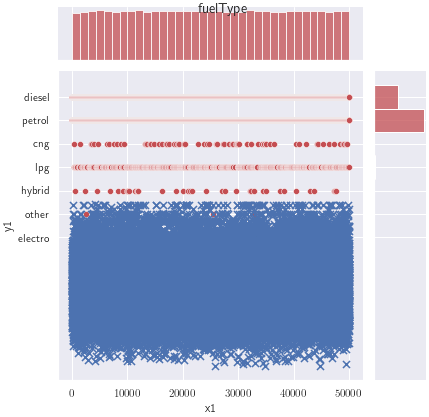

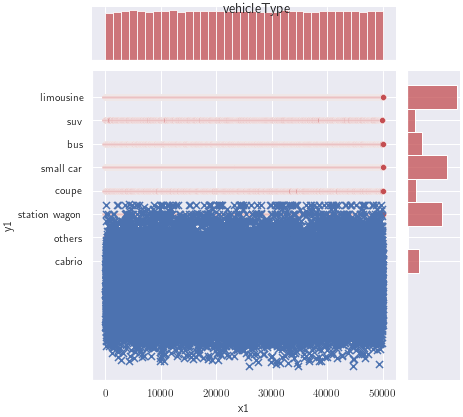

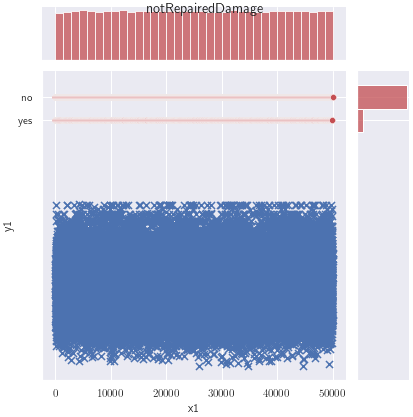

In [589]:
# совместное распределение нечисловых признаков с price
price = pd.DataFrame(tidy['price'].reset_index().to_numpy(), columns=['x2', 'y2'])

for i, col in enumerate(['gearbox', 'fuelType', 'vehicleType', 'notRepairedDamage']):
    feature = pd.DataFrame(tidy[col].reset_index().to_numpy(), columns=['x1', 'y1'])
    graph = sns.jointplot(x=feature.x1, y=feature.y1, color='r')
    graph.x = price.x2
    graph.y = price.y2
    graph.plot_joint(plt.scatter, marker='x', c='b', s=50)
    graph.fig.suptitle(col)

In [590]:
tidy['gearbox'].value_counts()

manual       32731
automatic     9336
Name: gearbox, dtype: int64

In [591]:
print(list(tidy['fuelType'].value_counts().items()))

[('petrol', 26449), ('diesel', 13020), ('lpg', 688), ('cng', 71), ('hybrid', 36), ('electro', 5), ('other', 3)]


In [592]:
# обобщим значения с низкой частотой до other

fuel_type = tidy['fuelType'].copy()
fuel_type[fuel_type.isin(['lpg', 'cng', 'hybrid', 'electro'])] = 'other'
tidy['fuelType'] = fuel_type

In [593]:
print(list(tidy['vehicleType'].value_counts().items()))

[('limousine', 11773), ('small car', 9337), ('station wagon', 8124), ('bus', 3623), ('cabrio', 2760), ('coupe', 2206), ('suv', 1829), ('others', 323)]


In [594]:
# заменим other на значение моды - limousine

vehicle_type = tidy['vehicleType'].copy()
vehicle_type[vehicle_type == 'others'] = 'limousine'
tidy['vehicleType'] = vehicle_type

In [595]:
tidy['notRepairedDamage'].value_counts()

no     32575
yes     4002
Name: notRepairedDamage, dtype: int64

## 7. Работа с пропусками

In [596]:
na = tidy.isna().sum()
print(f'n: {len(tidy)}')
na = na[na > 0]
na = pd.concat([na, na / len(tidy) * 100], axis=1)
na.columns = ['n', '%']
na

n: 42851


,n,%
vehicleType,2876,6.711629
gearbox,784,1.829596
model,1644,3.836550
fuelType,2579,6.018529
notRepairedDamage,6274,14.641432


In [597]:
# почти 15% пропусков в столбце notRepairedDamage - удаляем столбец

tidy: pd.DataFrame = tidy.drop(columns=['notRepairedDamage'])

In [598]:
print('Шкалы нечисловых данных:')
print(f'vehicleType: {tidy["vehicleType"].unique().tolist()}')
print(f'gearbox: {tidy["gearbox"].unique().tolist()}')
print(f'model: {str(tidy["model"].unique().tolist()[:10])[:-1]}, ...]')
print(f'fuelType: {tidy["fuelType"].unique().tolist()}')

Шкалы нечисловых данных:
vehicleType: ['limousine', 'suv', 'bus', 'small car', 'coupe', 'station wagon', nan, 'cabrio']
gearbox: ['manual', 'automatic', nan]
model: ['3er', 'xc_reihe', 'touran', 'ibiza', 'passat', 'clk', 'vectra', 'octavia', 'a_klasse', 'astra', ...]
fuelType: ['diesel', 'petrol', nan, 'other']


In [599]:
cols = ['vehicleType', 'gearbox', 'model', 'fuelType']
tidy[cols] = tidy[cols].fillna('mode')

## 8. Сохранение очищенного датасета

In [600]:
tidy.to_csv('out/tidy.csv', index=False)

In [601]:
df = pd.read_csv('out/tidy.csv')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,8.400659,test,limousine,2003,manual,5.010635,3er,150000,3,diesel,bmw,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,9.495444,control,suv,2005,manual,5.093750,xc_reihe,150000,6,diesel,volvo,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,8.070906,test,bus,2003,manual,4.615121,touran,150000,11,diesel,volkswagen,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,8.411833,control,small car,2006,manual,4.454347,ibiza,60000,12,petrol,seat,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,9.838949,test,suv,2008,automatic,5.220356,xc_reihe,150000,11,diesel,volvo,16/03/2016 0:00,55270,1/4/2016 23:18


In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42851 entries, 0 to 42850
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dateCrawled          42851 non-null  object 
 1   name                 42851 non-null  object 
 2   seller               42851 non-null  object 
 3   offerType            42851 non-null  object 
 4   price                42851 non-null  float64
 5   abtest               42851 non-null  object 
 6   vehicleType          42851 non-null  object 
 7   yearOfRegistration   42851 non-null  int64  
 8   gearbox              42851 non-null  object 
 9   powerPS              42851 non-null  float64
 10  model                42851 non-null  object 
 11  kilometer            42851 non-null  int64  
 12  monthOfRegistration  42851 non-null  int64  
 13  fuelType             42851 non-null  object 
 14  brand                42851 non-null  object 
 15  dateCreated          42851 non-null 

## Доп. 1. Модель регрессии для цены автомобиля

In [603]:
X = df[['powerPS', 'kilometer', 'gearbox', 'fuelType', 'vehicleType']]
y = df[['price']]

In [604]:
enc = OneHotEncoder()
X_bin = enc.fit_transform(X[['gearbox', 'fuelType', 'vehicleType']])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['powerPS', 'kilometer']])

X = pd.concat([pd.DataFrame(X_bin.toarray()), pd.DataFrame(X_scaled)], ignore_index=True, axis=1)

In [605]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [606]:
reg = LinearRegression()
reg.fit(X_train, y_train);

In [607]:
print(f'R2: {reg.score(X_test, y_test):.4f}')

R2: 0.5759
